In [1]:
import pyrosm as pr
from pyrosm import get_data

In [2]:
# Download file if not already available
fp = get_data('malaysia-singapore-brunei', directory='data/')

In [3]:
osm = pr.OSM(fp, [103.5338, 1.1295, 104.3028, 1.5921])

In [4]:
custom_filter = {'amenity': True, 'shop': True}

pois = osm.get_pois(custom_filter=custom_filter)
pois['poi_type'] = pois['amenity']
pois['poi_type'] = pois['poi_type'].fillna(pois['shop'])

/Users/jingjie/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/jingjie/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


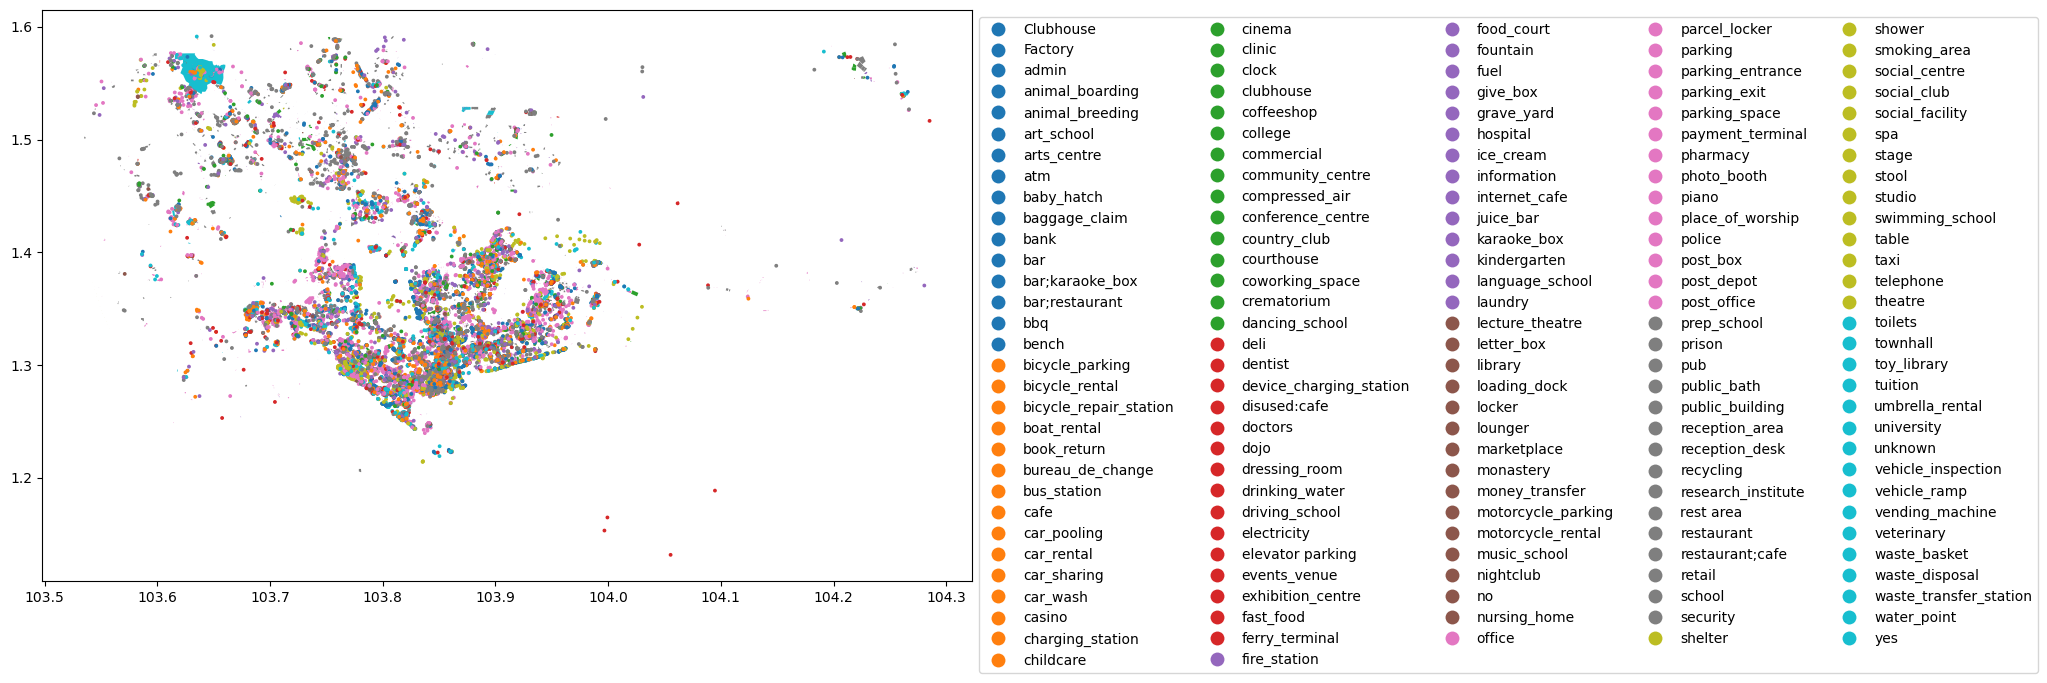

In [5]:
ax = pois.plot(column='amenity', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1,1)))